# Chapter 4: Adiabatic Quantum Computing and Quantum Annealing

## 4.2 Quantum annealing

let’s try to solve the MaxCut problem for the graph in Figure 3.5.

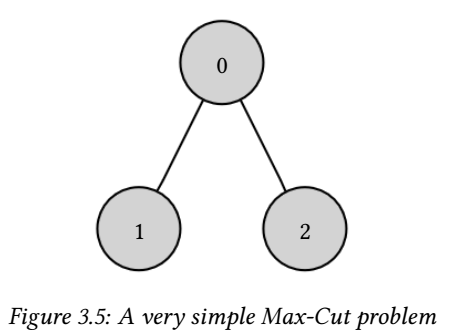

In [2]:
import dimod
J = {(0,1):1, (0,2):1}
h = {}
problem = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.SPIN)
print("The problem we are going to solve is:")
print(problem)

The problem we are going to solve is:
BinaryQuadraticModel({0: 0.0, 1: 0.0, 2: 0.0}, {(1, 0): 1.0, (2, 0): 1.0}, 0.0, 'SPIN')


Notice that the algorithm swap $J = {(0,1):1, (0,2):1}$ to ${(1,0):1, (2,0):1}$. But remember that the Hamiltonian is symetric, so there is no problem.

Unfortunately, Brazil does not have access to D-wave Leap. So we can not run the codes using its devices.

## 4.3 Using Ocean to formulate and transform optimization problems

Let's work with this problem once again:

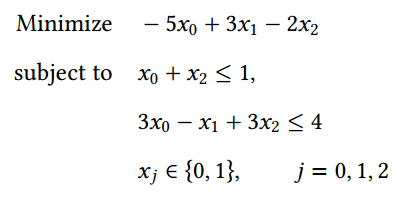

In [2]:
x0 = dimod.Binary("x0")
x1 = dimod.Binary("x1")
x2 = dimod.Binary("x2")

In [3]:
blp = dimod.ConstrainedQuadraticModel()
blp.set_objective(-5*x0+3*x1-2*x2)
blp.add_constraint(x0 + x2 <= 1, "First constraint")
blp.add_constraint(3*x0 -x1 + 3*x2 <= 4, "Second constraint")

'Second constraint'

In [4]:
print("Our variables are:")
print(blp.variables)
print("Our objective is:")
print(blp.objective)
print("Our constraints are:")
print(blp.constraints)

Our variables are:
Variables(['x0', 'x1', 'x2'])
Our objective is:
ObjectiveView({'x0': -5.0, 'x1': 3.0, 'x2': -2.0}, {}, 0.0, {'x0': 'BINARY', 'x1': 'BINARY', 'x2': 'BINARY'})
Our constraints are:
{'First constraint': Le(ConstraintView({'x0': 1.0, 'x2': 1.0}, {}, 0.0, {'x0': 'BINARY', 'x2': 'BINARY'}), 1.0), 'Second constraint': Le(ConstraintView({'x0': 3.0, 'x1': -1.0, 'x2': 3.0}, {}, 0.0, {'x0': 'BINARY', 'x1': 'BINARY', 'x2': 'BINARY'}), 4.0)}


### 4.3.2 Solving constrained quadratic models with dimod

We can atribuit values to the variables and verify their cost and if it is feasible.

In [5]:
sample1 = {"x0":1, "x1":1, "x2":1}
print("The assignment is", sample1)
print("Its cost is", blp.objective.energy(sample1))
print("Is it feasible?",blp.check_feasible(sample1))
print("The violations of the constraints are")
print(blp.violations(sample1))

The assignment is {'x0': 1, 'x1': 1, 'x2': 1}
Its cost is -4.0
Is it feasible? False
The violations of the constraints are
{'First constraint': 1.0, 'Second constraint': 1.0}


In [6]:
sample2 = {"x0":0, "x1":0, "x2":1}
print("The assignment is", sample2)
print("Its cost is", blp.objective.energy(sample2))
print("Is it feasible?",blp.check_feasible(sample2))
print("The violations of the constraints are")
print(blp.violations(sample2))

The assignment is {'x0': 0, 'x1': 0, 'x2': 1}
Its cost is -2.0
Is it feasible? True
The violations of the constraints are
{'First constraint': 0.0, 'Second constraint': -1.0}


In [7]:
solver = dimod.ExactCQMSolver()
solution = solver.sample_cqm(blp)
print("The list of assignments is")
print(solution)

The list of assignments is
  x0 x1 x2 energy num_oc. is_sat. is_fea.
6  1  0  1   -7.0       1 arra...   False
2  1  0  0   -5.0       1 arra...    True
7  1  1  1   -4.0       1 arra...   False
3  1  1  0   -2.0       1 arra...    True
4  0  0  1   -2.0       1 arra...    True
0  0  0  0    0.0       1 arra...    True
5  0  1  1    1.0       1 arra...    True
1  0  1  0    3.0       1 arra...    True
['INTEGER', 8 rows, 8 samples, 3 variables]


If you want the optimal solution to the problem, you should always remove the
unfeasible solutions first with the filter method, using an instruction like the following:

In [8]:
feasible_sols = solution.filter(lambda s: s.is_feasible)
print(feasible_sols)

  x0 x1 x2 energy num_oc. is_sat. is_fea.
2  1  0  0   -5.0       1 arra...    True
3  1  1  0   -2.0       1 arra...    True
4  0  0  1   -2.0       1 arra...    True
0  0  0  0    0.0       1 arra...    True
5  0  1  1    1.0       1 arra...    True
1  0  1  0    3.0       1 arra...    True
['INTEGER', 6 rows, 6 samples, 3 variables]


The solution is the first one.

In [9]:
solution.first

Sample(sample={'x0': 1, 'x1': 0, 'x2': 1}, energy=-7.0, num_occurrences=1, is_satisfied=array([False, False]), is_feasible=False)

### 4.3.3 Running constrained problems on quantum annealers

In [10]:
y0, y1 = dimod.Binaries(["y0", "y1"])
cqm = dimod.ConstrainedQuadraticModel()
cqm.set_objective(-2*y0-3*y1)
cqm.add_constraint(y0 + 2*y1 <= 2)

'c20ef7f'

We can transform this constrained problem into an unconstrained one by using the cqm_to_bqm method as follows:

In [11]:
qubo, invert = dimod.cqm_to_bqm(cqm, lagrange_multiplier = 5)
print(qubo)

BinaryQuadraticModel({'y0': -17.0, 'y1': -23.0, 'slack_vf359e1a3bb274143b600441b43173ab8_0': -15.0, 'slack_vf359e1a3bb274143b600441b43173ab8_1': -15.0}, {('y1', 'y0'): 20.0, ('slack_vf359e1a3bb274143b600441b43173ab8_0', 'y0'): 10.0, ('slack_vf359e1a3bb274143b600441b43173ab8_0', 'y1'): 20.0, ('slack_vf359e1a3bb274143b600441b43173ab8_1', 'y0'): 10.0, ('slack_vf359e1a3bb274143b600441b43173ab8_1', 'y1'): 20.0, ('slack_vf359e1a3bb274143b600441b43173ab8_1', 'slack_vf359e1a3bb274143b600441b43173ab8_0'): 10.0}, 20.0, 'BINARY')


Let's model our QUBO problem with dimod

In [12]:
y0, y1 = dimod.Binaries(["y0", "y1"])
cqm = dimod.ConstrainedQuadraticModel()
cqm.set_objective(-2*y0-3*y1)
cqm.add_constraint(y0 + 2*y1 <= 2)
qubo, invert = dimod.cqm_to_bqm(cqm, lagrange_multiplier = 5)
print(qubo)

BinaryQuadraticModel({'y0': -17.0, 'y1': -23.0, 'slack_vfe6528759c394662869b45e9b8bc7898_0': -15.0, 'slack_vfe6528759c394662869b45e9b8bc7898_1': -15.0}, {('y1', 'y0'): 20.0, ('slack_vfe6528759c394662869b45e9b8bc7898_0', 'y0'): 10.0, ('slack_vfe6528759c394662869b45e9b8bc7898_0', 'y1'): 20.0, ('slack_vfe6528759c394662869b45e9b8bc7898_1', 'y0'): 10.0, ('slack_vfe6528759c394662869b45e9b8bc7898_1', 'y1'): 20.0, ('slack_vfe6528759c394662869b45e9b8bc7898_1', 'slack_vfe6528759c394662869b45e9b8bc7898_0'): 10.0}, 20.0, 'BINARY')


The equality constraint is incorporated into the cost function as a penalty term with a penalty coeficient (the lagrange_multiplier parameter),which equals 5.